<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/Prohibited_language_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prohibited Language classification

Classification of foul language task using Bag of Words embeddings, TF-IDF, word vectors


## Imports

In [1]:
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn



from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [2]:
%matplotlib inline

## Load dataset

In [3]:
%%capture
!wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/NLP/Text_classification/data/comments.tsv

In [4]:
data = pd.read_csv('comments.tsv', sep='\t')

## Some basic EDA

In [5]:
data.head()

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   should_ban    1000 non-null   int64 
 1   comment_text  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


<Axes: xlabel='should_ban', ylabel='count'>

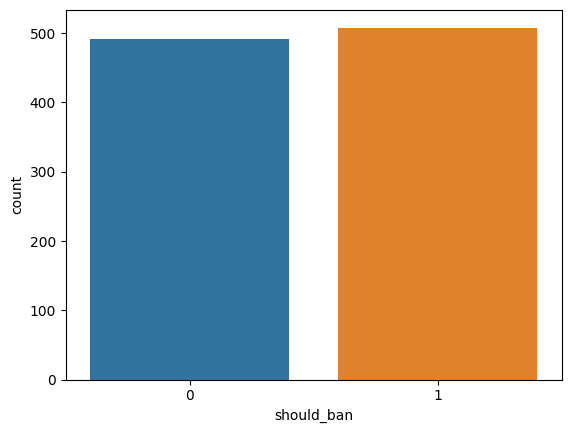

In [7]:
sns.countplot(data=data, x='should_ban')

In [8]:
data[data['comment_text'].str.len() <= 18]

,should_ban,comment_text
870,0,"No takers, then? ¦"


In [9]:
data[data['comment_text'].str.len() >=280]['comment_text'].count()

315

## Split data

In [10]:
X = data['comment_text'].values #data.drop('should_ban', axis=1)
y = data['should_ban'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Tokenize data

In [11]:
tokenizer = TweetTokenizer()
toker = lambda txt: ' '.join(tokenizer.tokenize(txt.lower()))
display(X_test[89])
toker(X_test[89])

'heY TOdds! Quick Q? \n\nWhy Are You So Gay'

'hey todds ! quick q ? why are you so gay'

In [12]:
v_tok = np.vectorize(toker)
texts_train = v_tok(X_train) #np.array([toker(x) for x in X_test])
texts_test = v_tok(X_test)

### Bathe in tests

In [13]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

## Baseline

In [14]:
tfidf = TfidfVectorizer(tokenizer=tokenizer.tokenize)
X_train_tfidf = tfidf.fit_transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.738
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       231
           1       0.78      0.71      0.75       269

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



## Write word counter over all documents

In [15]:
def get_freq_words(documents: np.ndarray)-> dict:
  '''Counts the number of words in all documents. Returns a dict {word:number}'''
  frequent_words = {}
  for doc in documents:
    doc = doc.split()
    for word in doc:
      frequent_words[word] = frequent_words.get(word, 0) +1
  return frequent_words


def sort_freq_words(word_freq: dict, k: int)-> list:
  '''Returns a sorted by occurency list of words with most frequent being first'''
  return sorted(word_freq.items(), key=lambda items: items[1], reverse=True)[:k]

In [16]:
k = 10000
word_frequency = get_freq_words(texts_train)
sorted_words = sort_freq_words(word_frequency, k)
bow_vocabulary = [token for token, n in sorted_words]
bow_vocabulary[:10]

['.', ',', 'you', 'the', '"', 'a', 'to', 'i', 'and', '!']

## Create Bag of Words embeddings

In [17]:
def text_to_bow(text: str)-> np.ndarray:
    """Convert text string to an array of token counts. Use bow_vocabulary."""
    bow_vector = np.zeros(len(bow_vocabulary))
    for word in text.split():
        if word in bow_vocabulary:
            bow_vector[bow_vocabulary.index(word)] += 1
    return bow_vector

In [18]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

### Bathe in tests

In [19]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

# Naive bayes

In [20]:
class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        self.p_y = np.array([np.mean(y==0), np.mean(y==1)])

        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive = np.sum(X[y==1], axis=0)
        word_counts_negative = np.sum(X[y==0], axis=0)
        # ^-- both must be vectors of shape [vocab_size].

        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1
        total_positive_words = np.sum(word_counts_positive) + BinaryNaiveBayes.delta * X.shape[1]
        total_negative_words = np.sum(word_counts_negative) + BinaryNaiveBayes.delta * X.shape[1]

        self.p_x_given_positive = (word_counts_positive + BinaryNaiveBayes.delta) / total_positive_words
        self.p_x_given_negative = (word_counts_negative + BinaryNaiveBayes.delta) / total_negative_words
        # both must be of shape [vocab_size]; and don't forget to add self.delta!
        print(self.p_x_given_positive.shape, self.p_x_given_negative.shape)
        return self


    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X
        score_negative = np.log(self.p_y[0]) + np.sum(np.log(self.p_x_given_negative)*X, axis=1)
        score_positive = np.log(self.p_y[1]) + np.sum(np.log(self.p_x_given_positive)*X, axis=1)

        # you can compute total p(x | y=k) with a dot product
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)


    def get_ratio(self):
        probability_ratio = self.p_x_given_negative / self.p_x_given_positive
        return np.argsort(probability_ratio)

    def get_ratio_in_vocab(self, vocab):
      return [self.p_x_given_negative[i] / self.p_x_given_positive[i] for i in range(len(vocab))]

In [21]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

(5707,) (5707,)


### Bathe in tests

In [22]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck')  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756
Well done!


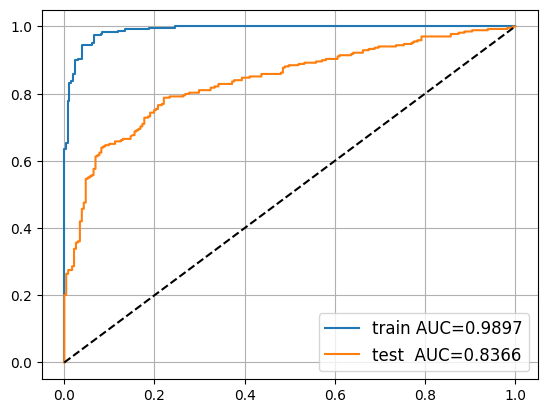

In [23]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

In [24]:
# hint: use naive_model.p_*
probability_ratio = naive_model.get_ratio() #<YOUR CODE: compute the ratio as defined above, must be a vector of [vocab_size]>
top_negative_words = [bow_vocabulary[i] for i in probability_ratio[:25]] #<YOUR CODE: find 25 words with highest probability_ratio, return list of str>


In [25]:
assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=337)
#1	      heil	(ratio=333)
#2	   offfuck	(ratio=380)
#3	      suck	(ratio=208)
#4	    nigger	(ratio=717)
#5	 j.delanoy	(ratio=686)
#6	      dick	(ratio=766)
#7	      fggt	(ratio=295)
#8	     bitch	(ratio=1354)
#9	      fuck	(ratio=1340)
#10	      slap	(ratio=1791)
#11	      shit	(ratio=1796)
#12	   fucking	(ratio=1588)
#13	       ass	(ratio=1604)
#14	    stupid	(ratio=2318)
#15	         =	(ratio=181)
#16	   college	(ratio=836)
#17	         *	(ratio=776)
#18	   asshole	(ratio=787)
#19	         u	(ratio=1593)
#20	   bastard	(ratio=3239)
#21	       hit	(ratio=3543)
#22	     idiot	(ratio=3459)
#23	         @	(ratio=3394)
#24	scientific	(ratio=2379)


In [26]:
bow_vocabulary[337]

'college'

#### The output words are right, but something seems wrong with the ratio interpretation

In [27]:
n_word = lambda n: bow_vocabulary[probability_ratio[n]]
n_score = lambda n: naive_model.p_x_given_negative[probability_ratio[n]] / naive_model.p_x_given_positive[probability_ratio[n]]
print(f'{n_word(0)}: {n_score(0)}')

hitler: 0.0021031669981914822


In [28]:
for i in range(len(top_negative_words)):
  print(f'{i+1}: {n_word(i)} {round(n_score(i),5)}')


1: hitler 0.0021
2: heil 0.00212
3: offfuck 0.00227
4: suck 0.00318
5: nigger 0.00447
6: j.delanoy 0.00455
7: dick 0.00535
8: fggt 0.01023
9: bitch 0.0167
10: fuck 0.01859
11: slap 0.02273
12: shit 0.02273
13: fucking 0.03147
14: ass 0.03719
15: stupid 0.05454
16: = 0.05701
17: college 0.05844
18: * 0.05844
19: asshole 0.06293
20: u 0.06545
21: bastard 0.06818
22: hit 0.06818
23: idiot 0.07438
24: @ 0.07438
25: scientific 0.08181


But since we are not allowed to change the test part let's consider the following code

In [29]:
from functools import cmp_to_key

inverted_bow = {word: idx for idx, word in enumerate(bow_vocabulary)}
proba_ratio = naive_model.get_ratio_in_vocab(bow_vocabulary)
top_neg_w = [w for w, idx in sorted(inverted_bow.items(), key=cmp_to_key(lambda i1, i2: proba_ratio[i1[1]]-proba_ratio[i2[1]]))][:25]

In [30]:
assert len(top_neg_w) == 25 and [isinstance(w, str) for w in top_neg_w]
assert 'j.delanoy' in top_neg_w and 'college' in top_neg_w

for i, word in enumerate(top_neg_w):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={proba_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=0.0021031669981914822)
#1	      heil	(ratio=0.00211951285569038)
#2	   offfuck	(ratio=0.002266293524366999)
#3	      suck	(ratio=0.003177211504064026)
#4	    nigger	(ratio=0.004470666460636539)
#5	 j.delanoy	(ratio=0.004545177568313815)
#6	      dick	(ratio=0.005347267727428018)
#7	      fggt	(ratio=0.010226649528706083)
#8	     bitch	(ratio=0.016696570659111974)
#9	      fuck	(ratio=0.01859390823401106)
#10	      shit	(ratio=0.022725887841569075)
#11	      slap	(ratio=0.022725887841569075)
#12	   fucking	(ratio=0.031466613934480255)
#13	       ass	(ratio=0.03718781646802212)
#14	    stupid	(ratio=0.05454213081976578)
#15	         =	(ratio=0.05701268029940674)
#16	         *	(ratio=0.05843799730689191)
#17	   college	(ratio=0.05843799730689191)
#18	   asshole	(ratio=0.06293322786896051)
#19	         u	(ratio=0.06545055698371893)
#20	   bastard	(ratio=0.06817766352470722)
#21	       hit	(ratio=0.06817766352470722)
#22	     idiot	(ratio=0.07437563293604424)
#23	     

### Apply logistics regression

In [31]:
bow_model = LogisticRegression(C=0.2)
bow_model.fit(X_train_bow, y_train)

LogisticRegression(C=0.2)

Model accuracy: 0.772
Well done!


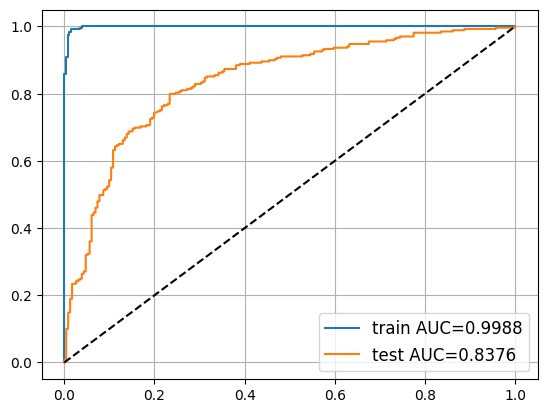

In [32]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:,1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label=f'{name} AUC={round(auc,4)}') # roc_curve(n)[:2] outputs [FP, TP].
    #area under ROC y=TP/(TP+FN), x=FP/(FP+TN)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

# custom TF-IDF

In [33]:
def word2dic(d: dict, word: str)-> dict:
  '''Increments value by 1
    Args:
          d (dict): Tictionary to update
          word (str): word to increment the value for
    Returns:
            a dict with incremented value
    '''
  if word in d:
    d[word] += 1
  else:
    d[word] = 1
  return d

In [34]:
def sorted_df(df:dict)->pd.DataFrame:
  '''Sorts values in dict and returns as pandas DataFrame'''
  dfdf = pd.DataFrame(sorted(df.items(), key=lambda item: item[1], reverse=True), columns=['Word', 'Frequency'])
  dfdf.set_index('Word',inplace=True)
  return dfdf

#### Term frequency

How often does a word appear in it's document (for every document)

In [35]:
def word_in_doc_num(doc: str) -> dict:
  '''For each word counts how frequent is it among the document'''
  doc_tf = {}
  for word in doc.split():
    doc_tf = word2dic(doc_tf, word)
  return doc_tf

In [36]:
def term_freq(docs: str):
  '''How often does the word appear in the document. For each document'''
  tf = []
  for doc in docs:
    doc_tf = word_in_doc_num(doc)
    tf.append(doc_tf)
  return tf

Create tf instance

In [37]:
tf = term_freq(texts_train)

#### Document Frequency

How often does the word appear across **ALL** documents

In [38]:
def doc_freq(tf: list)-> dict:
  '''For every word in every document count how often does it appear in ALL documents'''
  df = {}
  for doc in tf:
    for word in doc.keys():
      df = word2dic(df, word)
  return df

Create df instance

In [39]:
df = doc_freq(tf)

In [40]:
sorted_df(df)

,Frequency
Word,
.,384
",",290
the,288
to,253
you,251
...,...
fewer,1
od,1
slap,1


#### Inverse document frequency

Quantify the rarity of the each word across the documents. Emphasizing uncommon terms more.

In [41]:
def inv_doc_freq(docs_num: int, df: dict)-> dict:
  '''Takes log of (all docs amount / word frequency among all docs) '''
  idf = {}
  for word, freq in df.items():
    idf[word] = np.log((1+docs_num) / (freq+1)) + 1 #+1 to avoid neg vals
  return idf

Create inverse document frequency instance

In [42]:
idf = inv_doc_freq(len(texts_train), df)

In [43]:
sorted_df(idf)
#top values are the rarest

,Frequency
Word,
watches,6.523459
mytalk,6.523459
easier,6.523459
suppose,6.523459
88,6.523459
...,...
you,1.687177
to,1.679272
the,1.550179


#### TFIDF calculation

In [44]:
def calc_tfidf(tf, idf):
  tfidf = []
  for words in tf:
    tfidf_doc = {}
    for word, freq in words.items():
      tfidf_doc[word] = freq * idf[word]
    tfidf.append(tfidf_doc)
  return tfidf

In [45]:
def calc_norm_tfidf(tf, idf):
  tfidf = []
  for words in tf:
    tfidf_doc = {}
    docnorm = 0
    for word, freq in words.items():
      val = freq * idf[word]
      tfidf_doc[word] = val
      docnorm += val**2
    for word in tfidf_doc:
      tfidf_doc[word] /=docnorm

    tfidf.append(tfidf_doc)
  return tfidf

In [46]:
tfidf_result = calc_tfidf(tf, idf)
tfidf_result[25]

{'are': 2.3645758371652477,
 'you': 1.6871770135734416,
 'retarded': 5.607168188650764,
 '?': 4.926031819957,
 'how': 3.38796470459577,
 'did': 3.4324164671666035,
 'i': 1.791656083603462,
 'attack': 5.019381523748645,
 'an': 2.7739548445945483,
 'editor': 4.914021008090819,
 'grow': 6.117993812416755,
 'a': 1.7031773549198825,
 'brain': 6.117993812416755,
 ',': 1.5432828339133724,
 'numnut': 6.523458920524919,
 '.': 1.2633627667970806}

Combine altogether

In [47]:
def get_tfidf(documents):
  tf = term_freq(documents)
  df = doc_freq(tf)
  idf = inv_doc_freq(len(documents), df)
  tfidf = calc_norm_tfidf(tf, idf)
  return tfidf

Create tfidf for all docs train and test together for lulz and giggles

In [48]:
get_tfidf(np.concatenate((texts_train, texts_test), axis=0))[0]

{'...': 0.011133606776978364,
 'oh': 0.01589181300699841,
 'and': 0.0057534929410558095,
 'what': 0.009342159613732368,
 'kind': 0.01589181300699841,
 'of': 0.006035262556300936,
 'person': 0.014650494453258125,
 'watches': 0.02309866884130518,
 'another': 0.013508703370348757,
 'persons': 0.017946521520216127,
 'mytalk': 0.02309866884130518,
 'page': 0.0095676901131873,
 '?': 0.007706899968923075,
 'stalker': 0.020165430595149816,
 '!': 0.008454062342004786}

We're gonna use the same transformation we applied to train

In [49]:
custom_tfidf = get_tfidf(texts_train)
custom_tfidf[0]['and']

0.006417904133862377

In [50]:
X_train_tfidf[0, tfidf.vocabulary_['and']]

0.10644831564485613

Gonna need to find out why the difference is so huge (normalization?).

## Comapre TFIDF performance

#### Write roc auc func

In [51]:
def get_rocauc(X_train, X_test, y_train, y_test, modelX):
  for name, X, y, model in [
      ('train', X_train, y_train, modelX),
      ('test', X_test, y_test, modelX)
  ]:
      proba = model.predict_proba(X)[:,1]
      auc = roc_auc_score(y, proba)
      plt.plot(*roc_curve(y, proba)[:2], label=f'{name} AUC={round(auc,4)}')

  plt.plot([0, 1], [0, 1], '--', color='black',)
  plt.legend(fontsize='large')
  plt.grid()
  test_accuracy = np.mean(modelX.predict(X_test) == y_test)
  print(f"Model accuracy: {test_accuracy:.3f}")

### Get a func to evaluate the approach

In [64]:
def evaluate_logreg(train_X, test_X, c=3.9):
  logreg = LogisticRegression(C=c)
  logreg.fit(train_X, y_train)

  train_pred = logreg.predict(train_X)
  train_accuracy = accuracy_score(y_train, train_pred)

  test_pred = logreg.predict(test_X)
  test_accuracy = accuracy_score(y_test, test_pred)

  print('Accuracy train:', train_accuracy)
  print('Accuracy test:', test_accuracy)
  get_rocauc(train_X, test_X, y_train, y_test, logreg)

### Write custom TFIDF class to try on the model

In [60]:
class CustomTfidfVectorizer:
    def __init__(self, tokenizer=None, stop_words=None):
        self.tokenizer = tokenizer if tokenizer else self._default_tokenizer
        self.stop_words = stop_words if stop_words else ENGLISH_STOP_WORDS
        self.doc_count = 0
        self.word_doc_count = defaultdict(int)
        self.word_idf = {}


    def fit_transform(self, documents):
        tfidf_matrix = []
        for doc in documents:
            tfidf_vector = self.calculate_tfidf(doc)
            tfidf_matrix.append(tfidf_vector)
            self.doc_count += 1
        return np.array(tfidf_matrix)


    def _default_tokenizer(self, document):
        return document.split()


    def calculate_tfidf(self, document):
        tf_vector = defaultdict(int)
        for token in self.tokenizer(document):
            if token not in self.stop_words:
                tf_vector[token] += 1
        tfidf_vector = {}
        doc_length = sum(tf_vector.values())
        for word, tf in tf_vector.items():
            self.word_doc_count[word] += 1
            idf = np.log((1 + self.doc_count) / (1 + self.word_doc_count[word])) + 1
            tfidf_vector[word] = (tf / doc_length) * idf
        return tfidf_vector


    def transform(self, documents):
        tfidf_matrix = []
        for doc in documents:
            tfidf_vector = self.calculate_tfidf(doc)
            tfidf_matrix.append(tfidf_vector)
        return np.array(tfidf_matrix)


    def normalize(self, tfidf_matrix):
      normalized = []
      for doc_tfidf in tfidf_matrix:
        norm = np.linalg.norm(list(doc_tfidf.values()))
        norm_vec = {word: tfidf / norm for word, tfidf in doc_tfidf.items()}
        normalized.append(norm_vec)
      return np.array(normalized)

#### Create instance and set up transformation

In [61]:
custom_tfidf_vectorizer = CustomTfidfVectorizer()

custom_tfidf_train = custom_tfidf_vectorizer.fit_transform(texts_train)
custom_tfidf_test = custom_tfidf_vectorizer.transform(texts_test)

custom_tfidf_train = custom_tfidf_vectorizer.normalize(custom_tfidf_train)
custom_tfidf_test = custom_tfidf_vectorizer.normalize(custom_tfidf_test)

In [62]:
all_words = set()
for doc in custom_tfidf_train:
    all_words.update(doc.keys())

num_tfidf_train = np.array([[doc.get(word, 0) for word in all_words] for doc in custom_tfidf_train])
num_tfidf_test = np.array([[doc.get(word, 0) for word in all_words] for doc in custom_tfidf_test])

Accuracy train: 0.98
Accuracy test: 0.766
Model accuracy: 0.766


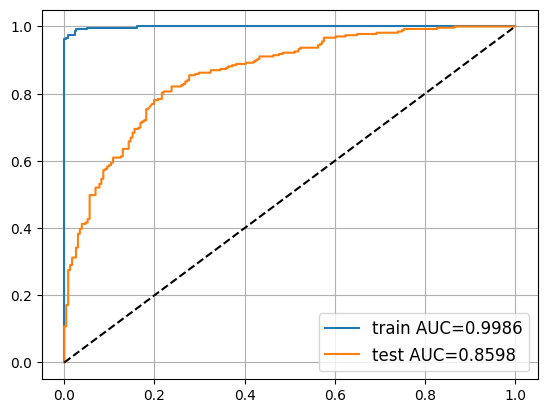

In [94]:
evaluate_logreg(num_tfidf_train, num_tfidf_test)

### Try sklearn TFIDF vectorization from the box

Accuracy train: 0.982
Accuracy test: 0.79
Model accuracy: 0.790


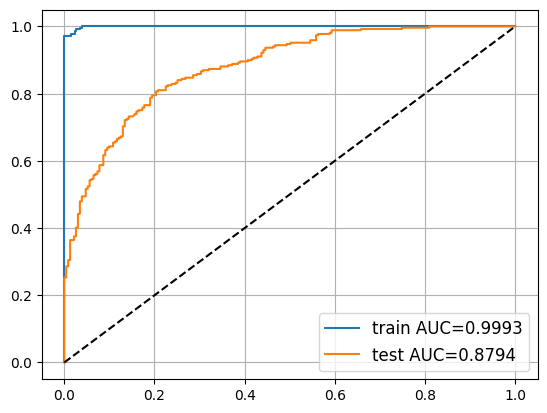

In [57]:
evaluate_logreg(X_train_tfidf, X_test_tfidf)

75.2% vs 79.0%
Of course sklearn model would be a bit better than the custom one.

After introducing normalization on the same C gained 1% by if we tinker with regularization parameter C, we can achieve the result close to the one in sklearn.

Accuracy train: 0.964
Accuracy test: 0.788
Model accuracy: 0.788


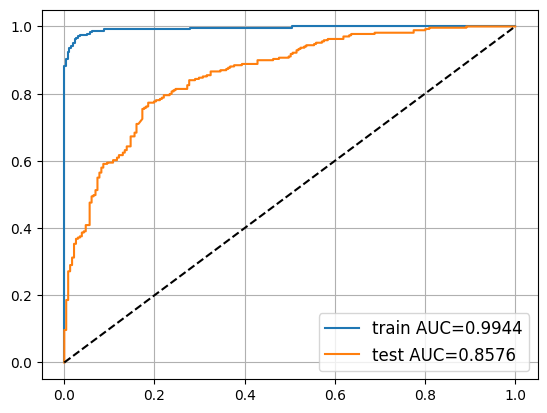

In [95]:
evaluate_logreg(num_tfidf_train, num_tfidf_test, c=2.4)

78.8% is much closer to 78% than 75.2% and 76.6%